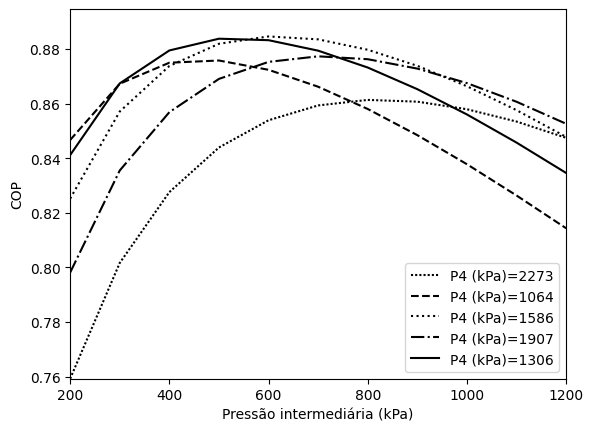

In [3]:
from CoolProp.CoolProp import PropsSI as COOLPROP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Listas
registro_fluidos = []
COP_lista = []
P_int_lista = []
P4_lista = []
Wcomp_total_lista = []
cont = []

#Lista de Temperaturas
for T5 in range (-3000 + 27315, 300 + 27315, 700):
    T5 = T5 / 100
    cont.append(T5)

#Parâmetros
Pfrig = 120 * 1000
T1 = -80 + 273.15
T11 = 28 + 273.15
N = 0.7 #Eficiência isentrópica
fluid_high_lista = ['R600']
fluid_low_lista = ['R170']
drop_suc = 0 #[Pa]
drop_desc = 0 #[Pa]
DeltaT = 0.01 #[°C]

#Loop nos dois ciclos - variação dos refrigerantes e do coeficiente politrópico
for P_int in range (200000, 1200001, 100000):  
    for fluid_low in fluid_low_lista:
        for fluid_high in fluid_high_lista:
            par_fluido = (fluid_low, fluid_high)
            registro_fluidos.append(par_fluido)
             #Temperatura T5
            for T5 in cont:
                #Pressão crítica do fluido superior
                P_crit_high = COOLPROP('PCRIT', fluid_high)
                #Ciclo inferior
                P1 = COOLPROP('P', 'T', T1, 'Q', 1, fluid_low)
                P5 = COOLPROP('P', 'T', T5, 'Q', 0, fluid_low)
                h5 = COOLPROP('H', 'T', T5, 'Q', 0, fluid_low)
                h6 = h5
                #Pressão intermediária

                P6 = P_int
                P3 = P_int
                P7 = P_int
                P2 = P_int
                h7 = COOLPROP('H', 'P', P7, 'Q', 0, fluid_low)
                h8 = h7
                h3 = COOLPROP('H', 'P', P3, 'Q', 1, fluid_low)
                h1 = COOLPROP('H', 'T', T1, 'Q', 1, fluid_low)
                #CBP
                ha = h1
                Pa = P1 - drop_suc
                Ta = COOLPROP('T', 'H', ha, 'P', Pa, fluid_low)
                Pb = Pa
                Tb = Ta + DeltaT
                hb = COOLPROP('H', 'T', Tb, 'P', Pb, fluid_low)
                Sb = COOLPROP('S', 'T', Tb, 'P', Pb, fluid_low)
                Pc = P2 + drop_desc
                Sc_ideal = Sb     
                hc_ideal = COOLPROP('H', 'S', Sc_ideal , 'P', Pc, fluid_low)
                hc_real = (hc_ideal - hb)/N + hb
                h2 = hc_real

                m_CBP = Pfrig / (h1 - h8)
                #CAP
                hw = h3
                Pw = P3 - drop_suc
                Tw = COOLPROP('T', 'H', hw, 'P', Pw, fluid_low)
                Px = Pw
                Tx = Tw + DeltaT
                hx = COOLPROP('H', 'P', Px, 'T', Tx, fluid_low)
                sx = COOLPROP('S', 'P', Px, 'T', Tx, fluid_low)
                P4 = P5
                Py = P4 + drop_desc
                sy_ideal = sx
                hy_ideal = COOLPROP('H', 'P', Py, 'S', sy_ideal, fluid_low)
                hy_real = (hy_ideal - hx)/N + hx
                h4 = hy_real

                #Ciclo superior
                h11 = COOLPROP('H', 'T', T11, 'Q', 0, fluid_high)
                T12 = T5 - 5
                h12 = h11 
                P12 = COOLPROP('P', 'T', T12, 'Q', 0, fluid_high)

                P9 = P12
                h9 = COOLPROP('H', 'P', P9, 'Q', 1, fluid_high)
                T9 = COOLPROP('T', 'P', P9, 'Q', 1, fluid_high)
                he = h9
                Pe = P9 - drop_suc
                Te = COOLPROP ('T', 'H', he, 'P', Pe, fluid_high)
                Pf = Pe
                Tf = Te + DeltaT
                hf = COOLPROP('H', 'P', Pf, 'T', Tf, fluid_high)
                sf = COOLPROP('S', 'P', Pf, 'T', Tf, fluid_high)

                P11 = COOLPROP('P', 'T', T11, 'Q', 0, fluid_high)
                P10 = P11
                Pg = P10 + drop_desc
                sg_ideal = sf
                hg_ideal = COOLPROP('H', 'P', Pg, 'S', sg_ideal, fluid_high)
                hg_real = (hg_ideal - hf)/N + hf


                #Trabalho específico do CBP
                w_CBP = hc_real - hb
                #Trabalho do CBP
                W_CBP = m_CBP * w_CBP
                #CAP
                m_CAP = m_CBP * (h7 - h2) / (h6 - h3)
                #Trabalho específico do CAP
                w_CAP = hy_real - hx
                #Trabalho do CAP
                W_CAP = m_CAP * w_CAP
                #Trabalho total no ciclo inferior
                W_low_total = W_CAP + W_CBP
                #Calor trocado no trocador central
                Qcond_low =  m_CAP * (h4 - h5)
                #Ciclo superior
                Qevap_high = Qcond_low
                m_flow_high = Qevap_high / (h9 - h12)
                #Verificação da pressão crítica
                if P_crit_high > P10:
                    P_int_lista.append(P_int/1000)
                    P4_lista.append(P4/1000)
                    #Trabalho específico do compressor do ciclo superior
                    w_high = hg_real - hf
                    #Trabalho do compressor do ciclo superior
                    Wcomp_high = m_flow_high * w_high
                    #Trabalho total
                    Wcomp_total = Wcomp_high + W_low_total
                    Wcomp_total_lista.append(Wcomp_total / 1000)
                    #COP
                    COP = Pfrig / Wcomp_total
                    COP_lista.append(COP)
                else:
                    print ('A pressão P10 = {:0.2f} kPa (T5 = {}, fluido inf = {}, fluido sup = {}) é maior do que a ' 
                   'pressão crítica do {} e, por isso, o ponto não foi incluído no gráfico'.format(P10 / 1000,T5,fluid_low,
                                                                                               fluid_high, fluid_high))    

      
x = P_int_lista
z = P4_lista
y = COP_lista

# Define um dicionário que mapeia os valores de z para estilos de linha diferentes
z_linestyles = {z_val: linestyle for z_val, linestyle in zip(set(z), [(0, (1, 1)),'--', ':', '-.','-'])}

# Cria uma figura com um gráfico 2D
fig, ax = plt.subplots()

# Itera sobre os valores únicos de z
for z_val in set(z):
    # Seleciona os pontos correspondentes a z_val
    x_val = [x[i] for i in range(len(x)) if z[i] == z_val]
    y_val = [y[i] for i in range(len(y)) if z[i] == z_val]

    # Plota os pontos com uma linha ligando eles
    ax.plot(x_val, y_val, linestyle=z_linestyles[z_val], color='black', label=f'P4 (kPa)={int(z_val)}')

# Define os limites dos eixos X e Y
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y)+0.01)

# Define os rótulos dos eixos X e Y
ax.set_xlabel('Pressão intermediária (kPa)')
ax.set_ylabel('COP')

# Adiciona a legenda
ax.legend()


# Mostra o gráfico
plt.show()
